# Calculate SPI indicators

## Use 20th Century (1901-2000) as calibration period for SPI distribution fit. 

Note: in the CRU contribution to State of the Climate (See pub, J. Barichivich, T. J. Osborn, I. Harris, G. van der Schrier, and P. D. Jones) they used the whole dataset to calibrate the index. They also show the % of global land area showing moderate, severe, extreme drought conditions as defined by Self-calibrating Palmer Drought Severity Index (scPDSI) https://crudata.uea.ac.uk/cru/data/drought/. This is an alternative to SPI, tries to account for soil moisture through including temperature as well as precipitation (i.e. hot and dry is different/worse than cool and dry). There is not really a great way to choose between all these variants - all indexes have limitations. SPI does have advantage of being very straightforwards, it just gives you an idea of the position of a given month within the distribution. But could argue it doesn't say enough w.r.t actual impacts.

The State of Climate publications seems to confirm that there is no net trend in the global total areas affected by drought. They note in their commentary the individual effects of local drought events e.g. 2million people affected in Afghanistan or forest fires in Sweden. So there remains a certain inconsistency between the global means/total and the impacts. It seems drought impacts are being felt but this is not being picked up by the indicators - why is that? 

I suspect that the purely meteorological drought indicators lack important information about vulnerability - e.g. the correlation with food insecurity or the potential for wildfires. Mixing all these things into one indicator might not be a good idea even so - rather there is need to cross reference several indicators to get a complete picture, maybe look at some correlations.

As for underlying cause of the limited evidence for global trends, my guess is its because climate change hasn't (yet) made a significant change to the total water circulating in the hydrological cycle, so the net precipitation over the world isn't show much of a trend - increases in one place are matched by decreases somewhere else so the net flow is the same. Could try to think of a way to capture increasing local extremes - but actually the 'area in drought' calculation should already do that because it only considers drought affected areas (i.e. there isn't the chance for increases to cancel out decreases in average rainfall). 

The real research question is then is there an increase in vulnerability (writ large) to drought? Are we really seeing more drought related impacts, or are we just paying more attention to them. Or is it that the current drought indicators are not properly capturing the real impacts at the global scale?


## Datasets

CRU monthly rainfall and mean temperatures. This is the only data really that goes back far enough for SPI calibration and also has good enough spatial resolution.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from climate_indices import indices, compute

from config import DATA_SRC, WEATHER_SRC

In [3]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [4]:
# CRU is always one year behind the rest
MAX_YEAR = 2018
SPI_OUT = DATA_SRC / 'lancet' / 'spi_calculations'

In [5]:
MAP_PROJECTION = ccrs.EckertIII()

In [6]:
cru_ppt = xr.open_dataset(WEATHER_SRC / 'cru'/ f'cru_ts4.03.1901.{MAX_YEAR}.pre.dat.nc', 
                        chunks={'lat':120, 'lon':60},
                        drop_variables=['stn', 'tmn'], engine='scipy')

In [7]:
data_start_year = np.asscalar(cru_ppt['time.year'][0])
data_start_year

1901

## Apply SPI 3-month calculation to CRU monthly precipitation data

Apply SPI calc to 1D slices of the input data, using the full time series from the start of the dataset until 2000. Since CRU dataset is 1 file anyway doesn't really matter...


In [9]:
spi3 = xr.apply_ufunc(indices.spi,
                      # SPI function arguments
                      cru_ppt.pre, 3, indices.Distribution.gamma, data_start_year, 1901, 2000, compute.Periodicity.monthly,
                      # Metadata
                      input_core_dims=(['time'],[],[],[],[],[],[]), 
                      output_core_dims=[['time']], 
                      vectorize=True,
                      dask='parallelized', 
                      output_dtypes=[np.float32])
spi3.name = 'spi3'

In [10]:
spi3 = spi3.compute()

In [11]:
spi3.to_netcdf(SPI_OUT/ f'spi3_cru_ts4.03_1901_{MAX_YEAR}_cru.nc')

## Apply SPI 6-month calculation to CRU monthly precipitation data

Apply SPI calc to 1D slices of the input data, using the full time series from the start of the dataset until 2000. Since CRU dataset is 1 file anyway doesn't really matter...


In [11]:
spi6 = xr.apply_ufunc(indices.spi,
                      # SPI function arguments
                      cru_ppt.pre, 6, indices.Distribution.gamma, data_start_year, 1901, 2000, compute.Periodicity.monthly,
                      # Metadata
                      input_core_dims=(['time'],[],[],[],[],[],[]), 
                      output_core_dims=[['time']], 
                      vectorize=True,
                      dask='parallelized', 
                      output_dtypes=[np.float32])
spi6.name = 'spi6'

In [12]:
spi6 = spi6.compute()

In [17]:
spi6.to_netcdf(SPI_OUT/ f'spi6_cru_ts4.03_1901_{MAX_YEAR}_cru.nc')

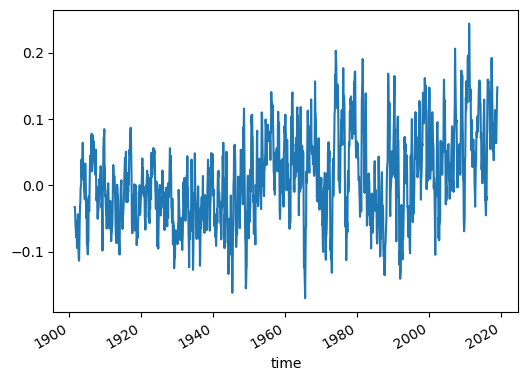

In [31]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(spi6.lat))
(spi6 * cos_lat).mean(dim=['lat', 'lon']).plot() 

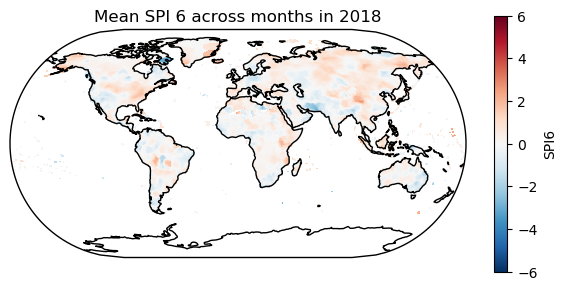

In [33]:
f, ax = plt.subplots(figsize=(6,3), subplot_kw= dict(projection=MAP_PROJECTION))
spi6.sel(time=f'{MAX_YEAR}').mean(dim='time').plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label='SPI6'),
    cmap='RdBu_r',
    vmin=-6, vmax=6
)
ax.coastlines()
ax.set(title=f'Mean SPI 6 across months in {MAX_YEAR}')
plt.tight_layout()
f.show()

## Apply SPI 12-month calculation to CRU monthly precipitation data

In [8]:
spi12 = xr.apply_ufunc(indices.spi,
                      # SPI function arguments
                      cru_ppt.pre, 12, indices.Distribution.gamma, data_start_year, 1901, 2000, compute.Periodicity.monthly,
                      # Metadata
                      input_core_dims=(['time'],[],[],[],[],[],[]), 
                      output_core_dims=[['time']], 
                      vectorize=True,
                      dask='parallelized', 
                      output_dtypes=[np.float32])
spi12.name = 'spi12'

In [9]:
spi12 = spi12.compute()

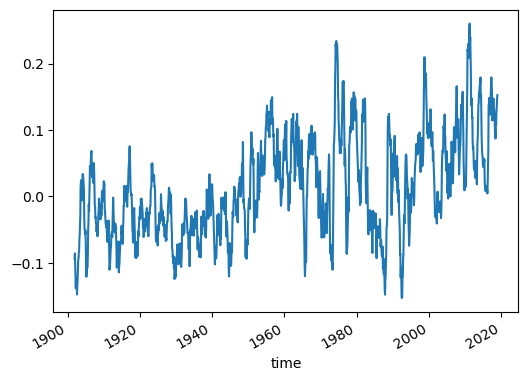

In [11]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(spi12.lat))
(spi12 * cos_lat).mean(dim=['lat', 'lon']).plot() 

In [9]:
spi12.to_netcdf(SPI_OUT/ f'spi12_cru_ts4.03_1901_{MAX_YEAR}_cru.nc')